In [183]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pickle as pkl
import cv2
import imutils
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import ResNet50V2, DenseNet121, VGG19, EfficientNetB7, InceptionV3, MobileNetV3Large
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_v2_preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Conv2DTranspose, Reshape, Input, ReLU, LeakyReLU
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy
import re

In [184]:
""" Dataset directories """
dataset_dir = "filtered_dataset"
# dataset_dir = "archive/Data"

In [185]:
""" Get the first image from the healthy directory """
first_image_file = os.listdir(f"{dataset_dir}/Not Dementia")[0]
img = plt.imread(f"{dataset_dir}/Not Dementia/{first_image_file}")

img_height, img_width, _ = img.shape

img_size = 224
# img_size = min(img_height, img_width)

print(f"Image size: {img_height}x{img_width} -> {img_size}x{img_size}")

Image size: 248x496 -> 224x224


#### General preprocessing and augmentation


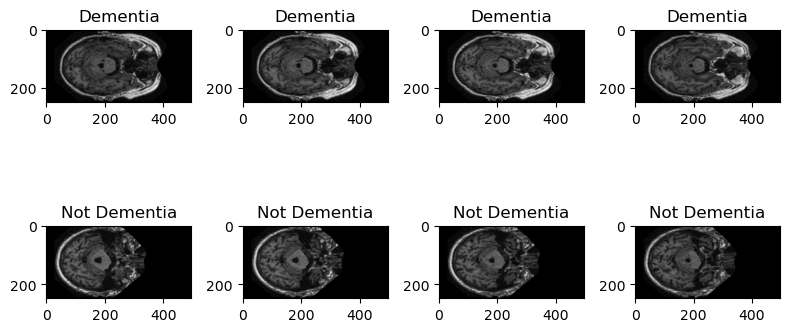

In [186]:
""" Display raw images from different classes """
plt.figure(figsize=(8, 8))

for i, subdir in enumerate(os.listdir(dataset_dir)):
    subdir_path = os.path.join(dataset_dir, subdir)
    img_files = os.listdir(subdir_path)[:4]

    for j, img_file in enumerate(img_files):
        img_path = os.path.join(subdir_path, img_file)
        img = plt.imread(img_path)

        plt.subplot(4, 4, i * 4 + j + 1)
        plt.imshow(img)
        plt.title(subdir)

plt.tight_layout()
plt.show()

#### Custom preprocessing on Images


In [187]:
def apply_clahe(img):
    # Convert image to grayscale
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_img = clahe.apply(grayscale_img)

    return equalized_img


def enhance_sharpness(img):
    # Apply Laplacian sharpening to enhance details
    laplacian = cv2.Laplacian(img, cv2.CV_8U, ksize=3)

    # Add the original image with the sharpened details
    sharpened_img = cv2.addWeighted(img, 1.5, laplacian, -0.5, 0)

    return sharpened_img


def crop_image(img, add_pixels_value=1):
    # Apply Gaussian blur to reduce noise
    gray_blur = cv2.GaussianBlur(img, (5, 5), 0)

    # Thresholding to create a binary image
    _, thresh = cv2.threshold(gray_blur, 45, 255, cv2.THRESH_BINARY)

    # Morphological operations (erosion and dilation) to remove noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    # If no contours found, return original image
    if len(contours) == 0:
        return img

    # Get the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Add extra pixels to the bounding box if specified
    x -= add_pixels_value
    y -= add_pixels_value
    w += add_pixels_value * 2
    h += add_pixels_value * 2

    # Ensure the bounding box coordinates are within image bounds
    x = max(x, 0)
    y = max(y, 0)
    w = min(w, img.shape[1])
    h = min(h, img.shape[0])

    # Crop the image using the bounding box
    cropped_img = img[y : y + h, x : x + w].copy()

    return cropped_img


def resize_image(img, size):
    # Resize the image to the specified size
    resized_img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)

    return resized_img

In [188]:
"""
    Change run cell to True if you need the preprocessed images. Then keep toggle as False to only get the final preprocessed images.
"""

prep_dir_1 = "dataset_preprocessed_1_clahe"
prep_dir_2 = "dataset_preprocessed_2_sharp"
prep_dir_3 = "dataset_preprocessed_3_crop"
prep_dir_4 = "dataset_preprocessed_4_final"

# Flag for this cell
run_cell = True

if run_cell:
    # Local save intermediate outputs toggle
    toggle = False

    # Create directories if they don't exist
    for prep_dir in [prep_dir_1, prep_dir_2, prep_dir_3, prep_dir_4]:
        if not os.path.exists(prep_dir):
            os.makedirs(prep_dir)

    for subdir in os.listdir(dataset_dir):
        subdir_path = os.path.join(dataset_dir, subdir)

        # Create subdirectories in each preprocessing directory
        for prep_dir in [prep_dir_1, prep_dir_2, prep_dir_3, prep_dir_4]:
            new_subdir_path = os.path.join(prep_dir, subdir)
            if not os.path.exists(new_subdir_path):
                os.makedirs(new_subdir_path)

        for filename in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, filename)
            img = plt.imread(img_path)

            # Apply CLAHE and save the result in prep_dir_1
            clahe_img = apply_clahe(img)
            new_filename = os.path.join(prep_dir_1, subdir, filename)
            if toggle:
                plt.imsave(new_filename, clahe_img, cmap="gray")

            # Enhance sharpness and save the result in prep_dir_2
            sharp_img = enhance_sharpness(clahe_img)
            new_filename = os.path.join(prep_dir_2, subdir, filename)
            if toggle:
                plt.imsave(new_filename, sharp_img, cmap="gray")

            # Crop image and save the result in prep_dir_3
            cropp_image = crop_image(sharp_img)
            new_filename = os.path.join(prep_dir_3, subdir, filename)
            if toggle:
                plt.imsave(new_filename, cropp_image, cmap="gray")

            # Resize image to 224x224 and save the result in prep_dir_4
            preprocessed_img = resize_image(cropp_image, img_size)
            new_filename = os.path.join(prep_dir_4, subdir, filename)
            plt.imsave(new_filename, preprocessed_img, cmap="gray")

prep_dir = prep_dir_4

KeyboardInterrupt: 

#### Filter the Data

In [ ]:
# # Given images are in naming syntax of "OAS1_0001_MR1_mpr-1_100.jpg". I want to only keep the images that end between _120.jpg and _140.jpg
# pattern = re.compile(r".*_(12[0-9]|13[0-9]|140).jpg")

# for sub_dir in os.listdir(prep_dir):
#     for img_file in os.listdir(f"{prep_dir}/{sub_dir}"):
#         if not pattern.match(img_file):
#             os.remove(f"{prep_dir}/{sub_dir}/{img_file}")

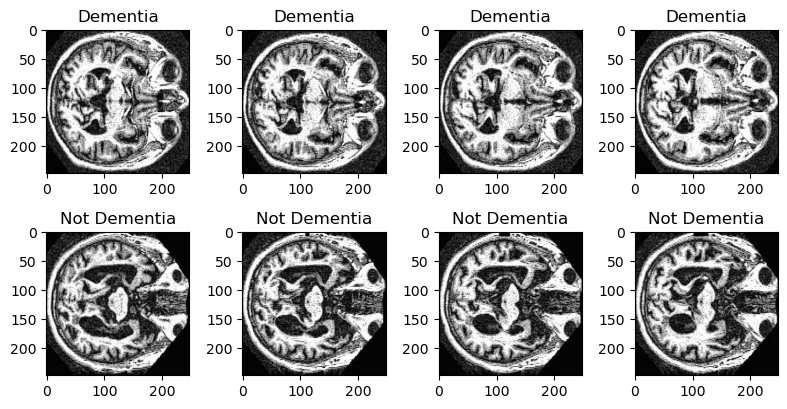

In [ ]:
""" Display raw images from different classes """
plt.figure(figsize=(8, 8))

for i, subdir in enumerate(os.listdir(prep_dir)):
    subdir_path = os.path.join(prep_dir, subdir)
    img_files = os.listdir(subdir_path)[:4]

    for j, img_file in enumerate(img_files):
        img_path = os.path.join(subdir_path, img_file)
        img = plt.imread(img_path)

        plt.subplot(4, 4, i * 4 + j + 1)
        plt.imshow(img)
        plt.title(subdir)

plt.tight_layout()
plt.show()

In [ ]:
""" Set batch size """
batch_size = 32

In [ ]:
""" Model configuration """
epochs_number = 200

""" Set optimizer """
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

""" Set early stopping """
early_stopping = EarlyStopping(monitor="val_accuracy", patience=8, min_delta=0.001, restore_best_weights=True)

""" Set learning rate annealer """
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=4, verbose=1, factor=0.75, min_lr=0.00001)

In [ ]:
train_datagen = ImageDataGenerator(
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=0.1,
    width_shift_range=0.1,
    rotation_range=20,
    validation_split=0.2,
)

val_datagen = ImageDataGenerator(
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(prep_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="training", shuffle=True, seed=42)
test_generator = val_datagen.flow_from_directory(prep_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="validation", shuffle=False, seed=42)

In [ ]:
""" Get class labels """
class_labels = list(train_generator.class_indices.keys())

In [ ]:
""" Number of classes"""
num_classes = len(class_labels)

## 1. Custom CNN model


In [ ]:
""" Model configuration """
epochs_number = 200

""" Set optimizer """
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

""" Set early stopping """
early_stopping = EarlyStopping(monitor="val_accuracy", patience=8, min_delta=0.001, restore_best_weights=True)

""" Set learning rate annealer """
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=4, verbose=1, factor=0.75, min_lr=0.00001)

In [ ]:
# Custom CNN architecture
custom_model = Sequential([
    Conv2D(32, (3, 3), input_shape=(img_size, img_size, 3)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3) ),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),
    Dense(512),
    ReLU(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
custom_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Show model summary
custom_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_129 (Bat (None, 222, 222, 32)      128       
_________________________________________________________________
re_lu_71 (ReLU)              (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_130 (Bat (None, 109, 109, 64)      256       
_________________________________________________________________
re_lu_72 (ReLU)              (None, 109, 109, 64)    

In [ ]:
# Train the model
custom_CNN_history = custom_model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples // batch_size, 
    epochs=epochs_number, 
    validation_data=test_generator, 
    validation_steps=test_generator.samples // batch_size, 
    callbacks=[learning_rate_reduction, early_stopping]
)

In [ ]:
# Save the trained model
custom_model.save("models/custom_CNN_model.h5")

# Save history
with open("models/custom_CNN_history.pkl", "wb") as f:
    pkl.dump(custom_CNN_history.history, f)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(custom_CNN_history.history["accuracy"], label="Training accuracy")
axs[0].plot(custom_CNN_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - Custom CNN")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(custom_CNN_history.history["loss"], label="Training loss")
axs[1].plot(custom_CNN_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - Custom CNN")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

## 2. EfficientNet-B7

In [ ]:
""" Model configuration """
epochs_number = 200

""" Set optimizer """
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

""" Set early stopping """
early_stopping = EarlyStopping(monitor="val_accuracy", patience=8, min_delta=0.001, restore_best_weights=True)

""" Set learning rate annealer """
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=4, verbose=1, factor=0.75, min_lr=0.00001)

In [ ]:
""" Load the EfficientNet model """
base_efficientNet_model = EfficientNetB7(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Unfreeze convolutional layers
for layer in base_efficientNet_model.layers:
    layer.trainable = True

# Add custom classification head and create model
efficientNet_model = Sequential([
    base_efficientNet_model,
    GlobalAveragePooling2D(),
    Dense(512),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")]
)

# Compile model
efficientNet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Show model summary
efficientNet_model.summary()

In [ ]:
# Train the model
efficientNet_history = efficientNet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_number,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[learning_rate_reduction, early_stopping],
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(efficientNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(efficientNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - EfficientNetB7")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(efficientNet_history.history["loss"], label="Training loss")
axs[1].plot(efficientNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - EfficientNetB7")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save trained model
efficientNet_model.save("models/efficientNet_model.h5")

# Save history
with open("models/efficientNet_history.pkl", "wb") as f:
    pkl.dump(efficientNet_history.history, f)

## 3. VGG19 model

In [ ]:
""" Model configuration """
epochs_number = 200

""" Set optimizer """
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

""" Set early stopping """
early_stopping = EarlyStopping(monitor="val_accuracy", patience=8, min_delta=0.001, restore_best_weights=True)

""" Set learning rate annealer """
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=4, verbose=1, factor=0.75, min_lr=0.00001)

In [ ]:
""" Load the VGG19 model """
base_vgg_model = VGG19(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Unfreeze convolutional layers
for layer in base_vgg_model.layers:
    layer.trainable = True

# Add custom classification head and create model
vgg_model = Sequential([
    base_vgg_model,
    GlobalAveragePooling2D(),
    Dense(512),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")]
)

# Compile model
vgg_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Show model summary
vgg_model.summary()

In [ ]:
# Train the model
vgg_history = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_number,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[learning_rate_reduction, early_stopping],
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(vgg_history.history["accuracy"], label="Training accuracy")
axs[0].plot(vgg_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - VGG19")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(vgg_history.history["loss"], label="Training loss")
axs[1].plot(vgg_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - VGG19")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model
vgg_model.save("models/vgg_model.h5")

# Save the history
with open("models/vgg_history.pkl", "wb") as f:
    pkl.dump(vgg_history.history, f)

## 4. ResNet-50 V2

In [ ]:
# Load ResNet50V2 model
base_resNet_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Unfreeze convolutional layers
for layer in base_resNet_model.layers:
    layer.trainable = True

# Add custom classification head and create model
resnet_model = Sequential([
    base_resNet_model,
    GlobalAveragePooling2D(),
    Dense(512),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")]
)

# Compile model
resnet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Show model summary
resnet_model.summary()

In [ ]:
""" Train model """
resNet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_number,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[learning_rate_reduction, early_stopping],
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

""" Plot training and validation accuracy """
axs[0].plot(resNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(resNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - ResNet50V2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

""" Plot training and validation loss """
axs[1].plot(resNet_history.history["loss"], label="Training loss")
axs[1].plot(resNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - ResNet50V2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
""" Save model """
resnet_model.save("models/resNet_model.h5")

""" Save history """
with open("models/resNet_history.pkl", "wb") as f:
    pkl.dump(resNet_history.history, f)

## 5. DenseNet-121 model


In [ ]:
""" Model configuration """
epochs_number = 200

""" Set optimizer """
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

""" Set early stopping """
early_stopping = EarlyStopping(monitor="val_accuracy", patience=8, min_delta=0.001, restore_best_weights=True)

""" Set learning rate annealer """
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=4, verbose=1, factor=0.75, min_lr=0.00001)

In [ ]:
# Load pre-trained DenseNet121 model
base_denseNet_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Unfreeze convolutional layers
for layer in base_denseNet_model.layers:
    layer.trainable = True

# Add custom classification head and create model
denseNet_model = Sequential([
    base_denseNet_model,
    GlobalAveragePooling2D(),
    Dense(512),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")]
)

# Compile model
denseNet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Show model summary
denseNet_model.summary()

In [ ]:
""" Train model """
denseNet_history = denseNet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_number,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[learning_rate_reduction, early_stopping],
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(denseNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(denseNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - DenseNet121")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(denseNet_history.history["loss"], label="Training loss")
axs[1].plot(denseNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - DenseNet121")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save trained model
denseNet_model.save("models/denseNet_model.h5")

# Save history
with open("models/denseNet_history.pkl", "wb") as f:
    pkl.dump(denseNet_history.history, f)

## 6. Inception-V3 model


In [ ]:
""" Model configuration """
epochs_number = 200

""" Set optimizer """
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

""" Set early stopping """
early_stopping = EarlyStopping(monitor="val_accuracy", patience=8, min_delta=0.001, restore_best_weights=True)

""" Set learning rate annealer """
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=4, verbose=1, factor=0.75, min_lr=0.00001)

In [ ]:
""" Load the Inception model """
base_inception_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Unfreeze convolutional layers
for layer in base_inception_model.layers:
    layer.trainable = True

# Add custom classification head and create model
inception_model = Sequential([
    base_inception_model,
    GlobalAveragePooling2D(),
    Dense(512),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")]
)

# Compile model
inception_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Show model summary
inception_model.summary()

In [ ]:
# Train the model
inception_history = inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_number,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[learning_rate_reduction, early_stopping],
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(inception_history.history["accuracy"], label="Training accuracy")
axs[0].plot(inception_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - InceptionV3")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(inception_history.history["loss"], label="Training loss")
axs[1].plot(inception_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - IncetionV3")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save trained model
inception_model.save("models/inception_model.h5")

# Save history
with open("models/inception_history.pkl", "wb") as f:
    pkl.dump(inception_history.history, f)

## 7. MobileNet model


In [ ]:
""" Model configuration """
epochs_number = 200

""" Set optimizer """
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

""" Set early stopping """
early_stopping = EarlyStopping(monitor="val_accuracy", patience=8, min_delta=0.001, restore_best_weights=True)

""" Set learning rate annealer """
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=4, verbose=1, factor=0.75, min_lr=0.00001)

In [ ]:
""" Load the MobileNet model """
base_mobileNet_model = MobileNetV3Large(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Unfreeze convolutional layers
for layer in base_mobileNet_model.layers:
    layer.trainable = True

# Add custom classification head and create model
mobileNet_model = Sequential([
    base_mobileNet_model,
    GlobalAveragePooling2D(),
    Dense(512),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")]
)

# Compile model
mobileNet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Show model summary
mobileNet_model.summary()

In [ ]:
# Train the model
mobileNet_history = mobileNet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_number,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[learning_rate_reduction, early_stopping],
)

In [ ]:
# Save trained model
mobileNet_model.save("models/mobileNet_model.h5")

# Save history
with open("models/mobileNet_history.pkl", "wb") as f:
    pkl.dump(mobileNet_history.history, f)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(mobileNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(mobileNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - MobileNetV3")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(mobileNet_history.history["loss"], label="Training loss")
axs[1].plot(mobileNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - MobileNetV3")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

## Evaluate models


In [ ]:
# Table comparing the performance of models
resNet_accuracy = resNet_history.history["accuracy"][-1]
resNet_val_accuracy = resNet_history.history["val_accuracy"][-1]

denseNet_accuracy = denseNet_history.history["accuracy"][-1]
denseNet_val_accuracy = denseNet_history.history["val_accuracy"][-1]

vgg_accuracy = vgg_history.history["accuracy"][-1]
vgg_val_accuracy = vgg_history.history["val_accuracy"][-1]

inception_accuracy = inception_history.history["accuracy"][-1]
inception_val_accuracy = inception_history.history["val_accuracy"][-1]

mobileNet_accuracy = mobileNet_history.history["accuracy"][-1]
mobileNet_val_accuracy = mobileNet_history.history["val_accuracy"][-1]

efficientNet_accuracy = efficientNet_history.history["accuracy"][-1]
efficientNet_val_accuracy = efficientNet_history.history["val_accuracy"][-1]

custom_CNN_accuracy = custom_CNN_history.history["accuracy"][-1]
custom_CNN_val_accuracy = custom_CNN_history.history["val_accuracy"][-1]

model_comparison = pd.DataFrame(
    {
        "Model": [
            "ResNet50V2",
            "DenseNet121",
            "VGG19",
            "InceptionV3",
            "MobileNetV3",
            "EfficientNetB7",
            "Custom CNN"
        ],
        "Train Accuracy": [
            resNet_accuracy,
            denseNet_accuracy,
            vgg_accuracy,
            inception_accuracy,
            mobileNet_accuracy,
            efficientNet_accuracy,
            custom_CNN_accuracy,
        ],
        "Validation Accuracy": [
            resNet_val_accuracy,
            denseNet_val_accuracy,
            vgg_val_accuracy,
            inception_val_accuracy,
            mobileNet_val_accuracy,
            efficientNet_val_accuracy,
            custom_CNN_val_accuracy,
        ],
    }
)

# Sort the models by validation accuracy
model_comparison = model_comparison.sort_values(by="Validation Accuracy", ascending=False).reset_index(drop=True)

model_comparison

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Validation Accuracy", data=model_comparison, palette="viridis")
plt.title("Comparison of Validation Accuracies")
plt.show()

In [ ]:
# import visualkeras

# model = vgg_model

# # visualkeras.layered_view(model).show()
# # visualkeras.layered_view(model, to_file='output.png')
# # visualkeras.layered_view(model, to_file='output.png').show()

# visualkeras.layered_view(model)